# Background Generation

### Network Turbo

In [256]:
import subprocess
import os

result = subprocess.run('bash -c "source /etc/network_turbo && env | grep proxy"', shell=True, capture_output=True, text=True)
output = result.stdout
for line in output.splitlines():
    if '=' in line:
        var, value = line.split('=', 1)
        os.environ[var] = value

In [257]:
# !unset http_proxy && unset https_proxy

### Import Diffusers

In [258]:
from diffusers import (
    AutoencoderKL,
    ControlNetModel,
    DDPMScheduler,
    UNet2DConditionModel,
    UniPCMultistepScheduler,
)
from pipeline_controlnet_inpaint import StableDiffusionControlNetInpaintPipeline

from transformers import AutoTokenizer, PretrainedConfig
import torch
import os.path as osp

In [259]:
def import_model_class_from_model_name_or_path(pretrained_model_name_or_path: str, revision: str):
    text_encoder_config = PretrainedConfig.from_pretrained(
        pretrained_model_name_or_path,
        subfolder="text_encoder",
        revision=revision,
    )
    model_class = text_encoder_config.architectures[0]

    if model_class == "CLIPTextModel":
        from transformers import CLIPTextModel
        return CLIPTextModel
    
    elif model_class == "RobertaSeriesModelWithTransformation":
        from diffusers.pipelines.alt_diffusion.modeling_roberta_series import RobertaSeriesModelWithTransformation
        return RobertaSeriesModelWithTransformation
    else:
        raise ValueError(f"{model_class} is not supported.")

### Load checkpoints

In [260]:
ctrl_path = './rege_weights'

controlnet = ControlNetModel.from_pretrained(osp.join(ctrl_path, 'controlnet'))

tokenizer = AutoTokenizer.from_pretrained(osp.join(ctrl_path, 'tokenizer'),use_fast=False)


sd_inpainting_model_name = "stabilityai/stable-diffusion-2-inpainting"
# import correct text encoder class
text_encoder_cls = import_model_class_from_model_name_or_path(sd_inpainting_model_name, None)

# Load scheduler and models
noise_scheduler = DDPMScheduler.from_pretrained(osp.join(ctrl_path, "scheduler"))

text_encoder = text_encoder_cls.from_pretrained(osp.join(ctrl_path, "text_encoder"))

vae = AutoencoderKL.from_pretrained(osp.join(ctrl_path, "vae"))

unet = UNet2DConditionModel.from_pretrained(osp.join(ctrl_path, "unet"))

weight_dtype = torch.float32

pipeline = StableDiffusionControlNetInpaintPipeline.from_pretrained(
    sd_inpainting_model_name,
    vae=vae,
    text_encoder=text_encoder,
    tokenizer=tokenizer,
    unet=unet,
    controlnet=controlnet,
    safety_checker=None,
    revision=None,
    torch_dtype=weight_dtype,
)

print("End loading")

pipeline.scheduler = UniPCMultistepScheduler.from_config(pipeline.scheduler.config)
pipeline = pipeline.to('cuda')
pipeline.set_progress_bar_config(disable=True)

You are using a model of type clip_text_model to instantiate a model of type . This is not supported for all configurations of models and can yield errors.
Loading pipeline components...: 100%|██████████| 6/6 [00:00<00:00, 3115.74it/s]


End loading


### Load Image and resize

In [261]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
from efficient_sam import create_canvas_and_transform_image

img_name = 'images/radio.jpg'
image = cv2.imread(img_name)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

print(image.shape)

(1500, 1500, 3)


### Load SAM

In [262]:
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = osp.join('rege_weights/sam_weights','sam_vit_l_0b3195.pth')
model_type = "vit_l"
device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)
predictor.set_image(image)

In [263]:
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   

(-0.5, 1499.5, 1499.5, -0.5)

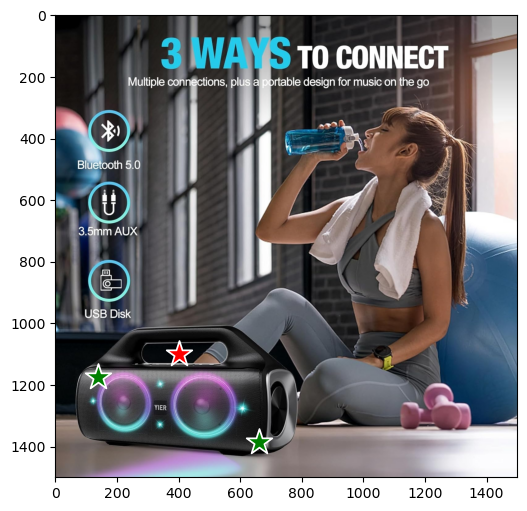

In [264]:
input_points = np.array([
    [138, 1174], [661, 1384], [400, 1100]
    ])
input_labels = np.array([1, 1, 0])
plt.figure(figsize=(6, 6))
sample_image_np = np.array(image)
plt.imshow(sample_image_np)
show_points(input_points, input_labels, plt.gca())
plt.axis('on')

In [265]:
def find_border(mask):
    top = np.argmax(mask.sum(axis=1) > 0)   # 上边界
    bottom = len(mask) - np.argmax(mask[::-1].sum(axis=1) > 0)# 下边界
    left = np.argmax(mask.sum(axis=0) > 0)  # 左边界
    right = len(mask[0]) - np.argmax(mask[:,::-1].sum(axis=0) > 0)  # 右边界

    return top, bottom, left, right


def get_crop_image_mask(sample_image_np, mask):
    # 保存为带有透明度的四通道BGRA格式：
    sample_image_np = sample_image_np.copy().astype(np.uint8)
    sample_image_np = cv2.cvtColor(sample_image_np, cv2.COLOR_RGB2BGRA)  # 转换为带有透明度的图像
    mask = np.where(mask, 255, 0).astype(np.uint8)
    sample_image_np[:,:,3] = mask  # 设置透明度
    # 找到蒙版的边界
    top, bottom, left, right = find_border(mask)
    # 根据边界裁剪图像
    cropped_image = sample_image_np[top:bottom, left:right]
    # 保存裁剪后的结果为带有透明度的PNG格式
    return cropped_image

In [266]:
masks, scores, logits = predictor.predict(
    point_coords=input_points,
    point_labels=input_labels,
    multimask_output=True,
)

bin_mask = masks[0]
cropped_image = get_crop_image_mask(sample_image_np, bin_mask)

### 商品的几何变换

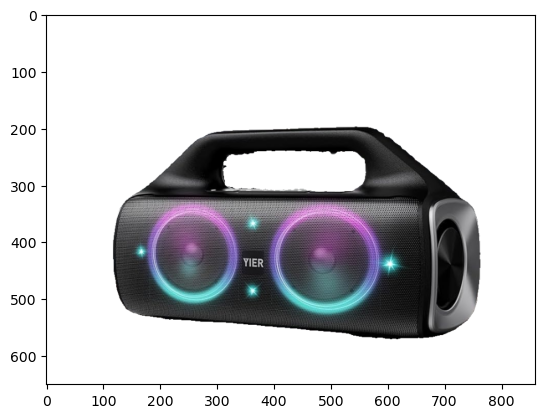

In [267]:
canvas_size = (650, 860)  # Example canvas size
scale_factor = 0.9  # Example scaling factor
rotation_angle = 0  # Example rotation angle in degrees
translation_xy = (10, 60)  # Example translation (x, y)

# Perform transformations and get the final image and mask
img_geo, mask = create_canvas_and_transform_image(
    cropped_image, canvas_size, scale_factor, rotation_angle, translation_xy)

img_geo = cv2.cvtColor(img_geo, cv2.COLOR_BGRA2RGBA)
plt.imshow(img_geo)
plt.show()

### 显示对应的mask

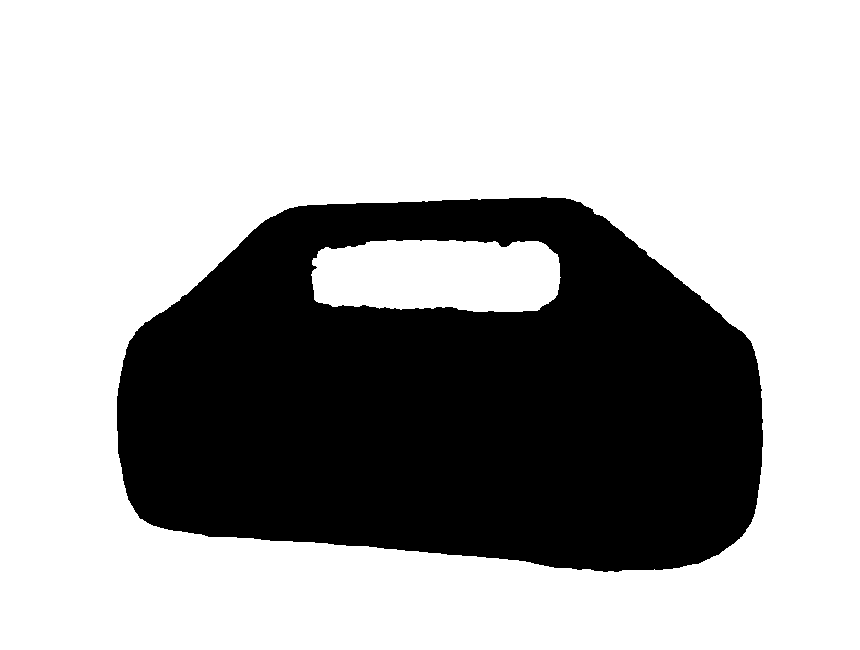

In [268]:
mask = np.where(mask, 255, 0).astype(np.uint8)
mask = Image.fromarray(mask , 'L')
mask = ImageOps.invert(mask)

mask

## Stable Diffusion with Controlnet (cond_scale = 1)

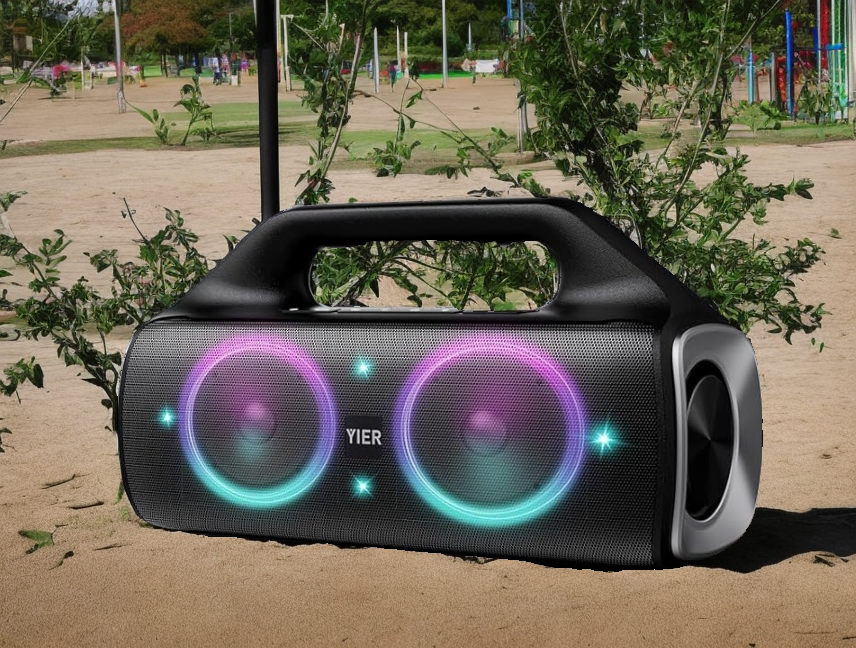

In [269]:
seed = 68
prompt = "a radio is placed on the ground of a playground"
img_geo = Image.fromarray(img_geo)
generator = torch.Generator(device='cuda').manual_seed(seed)
cond_scale = 1.0


with torch.autocast("cuda"):
    controlnet_image = pipeline(
        prompt=prompt, 
        image=img_geo, 
        mask_image=mask,
        control_image=mask, 
        num_images_per_prompt=1, 
        generator=generator, 
        num_inference_steps=20, 
        guess_mode=False, 
        controlnet_conditioning_scale=cond_scale
    ).images[0]
    
# controlnet_image

mask_image = mask.convert('1')
mask_image = ImageOps.invert(mask_image)

# 使用paste方法，根据mask覆盖掉ctrl_img中对应区域的像素
controlnet_image.paste(img_geo, (0, 0), mask_image)
controlnet_image.save('results/radio_rege_8.png')
controlnet_image